# Initializiation

In [10]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/MSBA/BA890/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/MSBA/BA890/data


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
! ls

ingr_map.pkl		interactions_validation.csv  RAW_interactions.csv
interactions_test.csv	PP_recipes.csv		     RAW_recipes.csv
interactions_train.csv	PP_users.csv


In [13]:
df_recipes = pd.read_csv('RAW_recipes.csv')
df_interact = pd.read_csv('RAW_interactions.csv')
train_interact = pd.read_csv('interactions_train.csv')

In [14]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [15]:
df_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [16]:
train_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


In [17]:
# join recipes on interactions to see which recipes are most popular
df = pd.merge(train_interact, df_recipes[['name','id']], left_on='recipe_id', right_on='id')
del df['id']

In [18]:
df.head()

,user_id,recipe_id,date,rating,u,i,name
0,2046,4684,2000-02-25,5.0,22095,44367,flank steak with lime chipotle sauce
1,12882,4684,2002-03-13,5.0,10399,44367,flank steak with lime chipotle sauce
2,37758,4684,2002-06-17,5.0,4954,44367,flank steak with lime chipotle sauce
3,37636,4684,2003-05-08,5.0,831,44367,flank steak with lime chipotle sauce
4,54697,4684,2003-06-30,5.0,1147,44367,flank steak with lime chipotle sauce


# Non-personalized Recommendations

This method will recommend recipes based on combiniations of recipes reviewers have cooked/reviewed over time. For example, if many reviewers cooked and reviewed a chicken pot pie recipe and an omelette recipe in the past, the omelette recipe may be recommended the next time someone views the chicken pot pie recipe.

In [10]:
df.shape

(698901, 7)

In [11]:
# had to drop observations due to RAM limitations
df2 = df.copy().sample(100000)
df2.shape

(100000, 7)

In [12]:
from itertools import permutations

# Create the function to find all permutations
def find_recipe_pairs(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['recipe_a', 'recipe_b'])
  return pairs

# Apply the function to the title column and reset the index
recipe_combinations = df2.groupby('user_id')['recipe_id'].apply(
  find_recipe_pairs).reset_index(drop=True)

print(recipe_combinations)

        recipe_a recipe_b
0          48475    27733
1          48475    22846
2          48475    24415
3          48475    63598
4          48475   113227
...          ...      ...
8105043   191473   134022
8105044    80964   299148
8105045   299148    80964
8105046   199579   108248
8105047   108248   199579

[8105048 rows x 2 columns]


In [13]:
combination_counts = recipe_combinations.groupby(['recipe_a', 'recipe_b']).size()

# Convert the results to a DataFrame and reset the index
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values('size', ascending=False, inplace=True)
combination_counts_df.head()

,recipe_a,recipe_b,size
1035075,54257,67256,8
370609,22782,39087,8
731147,39087,22782,8
1328751,67256,54257,8
1363947,68955,77397,6


Lets see what happens when we want to recommend the most reviewed recipe (best banana bread, id = 2886)

In [14]:
banana_bread = combination_counts_df[combination_counts_df['recipe_a'] == 2886]
banana_bread = pd.merge(banana_bread, df_recipes[['id','name']], how='inner', left_on='recipe_b', right_on = 'id')
banana_bread = banana_bread.rename(columns={'name':'recommendation'})
del banana_bread['id']
banana_bread.head(10)

,recipe_a,recipe_b,size,recommendation
0,2886,170649,2,crisp fried onions stegte log
1,2886,33671,2,crock pot whole chicken
2,2886,12365,2,reduced fat alfredo sauce
3,2886,79944,2,bacon wrapped chicken oamc
4,2886,67256,2,best ever banana cake with cream cheese frosting
5,2886,71876,1,kittencal s moist one bowl dark chocolate bund...
6,2886,71580,1,spinach marie
7,2886,71557,1,balsamic chicken thighs
8,2886,70282,1,baked german potato salad
9,2886,69479,1,caramel sauce


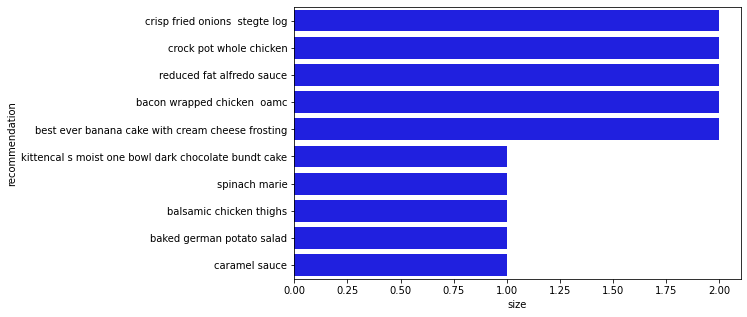

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=banana_bread.head(10), x='size', y='recommendation', color = 'blue')

Based on this non-personalized recommendation system, those who enjoyed making the banana bread may chose to cook: 
* crispy ginger beef
* crockpot chicken with black beans and cream cheese
* japanese mum's chicken
* (another) banana bread
* most incedible no fail pie crust

In [16]:
combination_counts_df.tail(15)

,recipe_a,recipe_b,size
2701737,132202,115444,1
2701724,132202,101101,1
2701736,132202,115235,1
2701735,132202,115073,1
2701734,132202,114658,1
2701733,132202,114281,1
2701732,132202,113697,1
2701731,132202,112645,1
2701730,132202,111734,1
2701729,132202,110806,1


With that said, this method may not work for recipes with very limited combinitations (or none). It may present a 'cold start' problem for recipes that are new and have not been reviewed by other users.

# Content-Based Recommendations

Content-based recommendations use the similarities of the recipes to provide recommendations. For example, if a user liked cooking an apple pie, they might also like blueberry pies on the account that they are both fruit-based pies. Another example could be that if someone liked cooking an italian dish like spaghetti bolognese, they might also like cooking lasagna.

The trouble with our current data is that there is no straightforward feature that could act as a comparison (e.g. *cuisine*). Therefore, we might need to do some NLP feature engineering.

Let's first try by using the name of the recipes.

In [59]:
# use sample of 5000 to minimize memory requirements
df_recipes2 = df_recipes.sample(5000, random_state=1)
df_recipes2.reset_index(drop=True, inplace=True)

### Using Count Vectorizer and Jaccard

In [18]:
# use Count Vectorizer to get count words in list of names
from sklearn.feature_extraction.text import CountVectorizer
V = CountVectorizer(stop_words = 'english') # initialize vectorizer with common stopwords

X = V.fit_transform(df_recipes2.name)
# V.get_feature_names()
# vectorizer.get_stop_words()

In [19]:
count_vect_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
count_vect_df

,007,10,101,11,12,123,140,15,1968,1998,1pt,1st,2008,21,24,2bleu,30,35,36,3pts,4th,4u,50,52,57,5fix,7points,a1,aarsi,abm,abricots,absolutely,acadia,acapulco,according,achiote,acorn,adams,adaptation,adapted,...,yellow,yemani,yemen,yemeni,yemista,yes,yigandes,yo,yoghurt,yogurt,york,yosemite,yucatan,yucca,yule,yum,yummiest,yummy,za,zabaglione,zalm,zard,zealand,zest,zesty,zinger,zings,zingy,zippy,ziti,zitronenvinaigrette,zo,zrigschntzlets,zucchini,zuppa,zurbian,zurich,zurie,zwina,zwt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# set name of recipe as index 
count_vect_df = count_vect_df.set_index(df_recipes2.name)

In [21]:
from scipy.spatial.distance import pdist, squareform

# calculating jaccard distances for each recipe
jaccard_distances = pdist(count_vect_df.values, metric='jaccard')
print(jaccard_distances)

[1. 1. 1. ... 1. 1. 1.]


In [22]:
# Convert the distances to a square matrix
jaccard_similarity_array = 1 - squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [23]:
jaccard_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.125,0.125,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
apricot and orange cream cream aux abricots et oranges,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714


Looking at sample of the recipes, it seems that we can find similarities already. 

'**nana's chicken seafood gumbo courtesy the neelys**' is similar to '**orange glazed barbecued chicken**' likely due to presence of the word 'chicken'

Let's see what else might be recommended if we cooked orange glazed barbecue chicken:

In [24]:
jaccard_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

,orange glazed barbecued chicken
name,
orange glazed barbecued chicken,1.000000
orange glazed breaded chicken,0.600000
simply yummy orange glazed chicken wings,0.428571
marinated barbecued chicken,0.400000
orange piccata chicken,0.400000
chutney glazed chicken,0.400000
soy glazed chicken thighs,0.333333
junior league barbecued chicken,0.333333
chinese zesty orange chicken,0.333333


For **orange glazed barbecued chicken**, this content-based recommender using the names of the recipes would recommend the following top 3 options:
1. orange glazed breaded chicken
2. simply yummy orange glazed chicken wings
3. marinated barbecued chicken

### Using TF-IDF and Cosine similarity

Now let's try using a different vectorizer and similarity metric. 

Without getting into the math, let's breakdown the main differenc between the vectorizers: unlike count vectorizer, TF-IDF takes into account how frequent the word appears in the bag of words. For example, if the word 'best' appears often in the name of the recipe, less weight is given to the vector score as opposed to somethine less frequent like 'glazed')

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
V = TfidfVectorizer(stop_words = 'english') # initialize vectorizer with common stopwords

X = V.fit_transform(df_recipes2.name)

In [26]:
tfidf_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
tfidf_df

,007,10,101,11,12,123,140,15,1968,1998,1pt,1st,2008,21,24,2bleu,30,35,36,3pts,4th,4u,50,52,57,5fix,7points,a1,aarsi,abm,abricots,absolutely,acadia,acapulco,according,achiote,acorn,adams,adaptation,adapted,...,yellow,yemani,yemen,yemeni,yemista,yes,yigandes,yo,yoghurt,yogurt,york,yosemite,yucatan,yucca,yule,yum,yummiest,yummy,za,zabaglione,zalm,zard,zealand,zest,zesty,zinger,zings,zingy,zippy,ziti,zitronenvinaigrette,zo,zrigschntzlets,zucchini,zuppa,zurbian,zurich,zurie,zwina,zwt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# set name of recipe as index 
tfidf_df = tfidf_df.set_index(df_recipes2.name)

In [28]:
from scipy.spatial.distance import pdist, squareform

# calculating jaccard distances for each recipe
cosine_distances = pdist(tfidf_df.values, metric='cosine')
print(cosine_distances)

[1. 1. 1. ... 1. 1. 1.]


In [29]:
# Convert the distances to a square matrix
cosine_similarity_array = 1 - squareform(cosine_distances)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [30]:
cosine_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.000000,0.0,0.0,0.0,0.052604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040654,0.0,0.0,0.0,0.059142,0.060595,0.0,0.050469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035245,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052226,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.053814,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
apricot and orange cream cream aux abricots et oranges,0.000000,0.0,0.0,0.0,0.123260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.181046,0.18701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.133868,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093450,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091545,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.09944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318996


As seen here, **nana's chicken seafood gumbo** is less similar to the **orange glazed barbecued chicken**, likely because the word 'chicken', which is where the similarity lies, appears many times in the bag of words (recipe names).

In [31]:
cosine_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

,orange glazed barbecued chicken
name,
orange glazed barbecued chicken,1.000000
orange glazed breaded chicken,0.590422
pork with orange glazed onions,0.540511
marinated barbecued chicken,0.514290
simply yummy orange glazed chicken wings,0.470644
chutney glazed chicken,0.452504
orange pan glazed tempeh recipe,0.428114
southern style honey barbecued chicken,0.407332
barbecued spareribs,0.395633


With the TF-IDF vectorizer and cosine similarity, the recommendations change a little.

### Using TF-IDF on ingredients instead of name

In [ ]:
df_recipes2.ingredients

0       ['red peppers', 'plum tomatoes', 'green onion'...
1       ['all-purpose flour', 'granulated sugar', 'bak...
2       ['refried beans', 'burrito-size flour tortilla...
3       ['baking potatoes', 'salt and black pepper', '...
4       ['orange juice', 'salt', 'red pepper flakes', ...
                              ...                        
4995    ['seasoned rice vinegar', 'sugar', 'soy sauce'...
4996    ['unsalted butter', 'granulated sugar', 'light...
4997    ['large shrimp', 'kosher salt', 'sugar', 'wate...
4998            ['olive', 'olive oil', 'lemon, juice of']
4999    ['peasant bread', 'olive oil', 'tomatoes', 'ga...
Name: ingredients, Length: 5000, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# # nulls present in description of 97 recipes, we're dropping those recipes 
# df_recipes2_no_nulls = df_recipes2.dropna(axis=0).reset_index()

# # sampling again because TF-IDF with bigrams on more words will be too much on RAM
# df_recipes2_no_nulls = df_recipes2_no_nulls.sample(500, random_state=1)

V = TfidfVectorizer(stop_words = 'english', analyzer=lambda d: d.split(', '))
X = V.fit_transform(df_recipes2.ingredients)

In [ ]:
tfidf_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
tfidf_df

,"""better 'n peanut butter spread""","""campbell's condensed cream of celery soup""","""campbell's condensed tomato soup""","""campbell's cream of mushroom soup""","""campbell's tomato soup""","""captain morgan's spiced rum""","""coleman's dry mustard""","""confectioners' sugar""","""confectioners' sugar""]","""devil's food cake mix""","""emeril's original essence""","""fleischmann's active dry yeast""","""frank's red hot sauce""","""goat's milk""","""hellmann's mayonnaise""","""i can't believe it's not butter fat free""","""lawry's seasoned salt""","""libby's canned pumpkin""","""m&m's plain chocolate candy""","""m&m's plain chocolate candy""]","""mccormick's montreal brand steak seasoning""","""mccormick's montreal brand steak seasoning""]","""mccormick's salt-free all-purpose seasoning""","""o'brien frozen potatoes""","""smucker's hot dark chocolate microwaveable topping""","""sweet 'n low""]","""taco bell home originals thick 'n chunky salsa""]","""yve's veggie ground round""","""za'atar spice mix""","""za'atar spice mix""]",'1% fat buttermilk','1% fat cottage cheese','1% fat cottage cheese'],'1% low-fat milk','2% cheddar cheese','2% evaporated milk','2% low-fat milk','2% low-fat milk'],'35% cream','7-inch flour tortillas',...,['whole turkey breast',['whole turkey',['whole wheat bread',['whole wheat flour',['whole wheat pastry flour',['whole wheat spaghetti',['whole wheat tortilla',['wholemeal self-rising flour',['wide egg noodles',['wild rice',['wine vinegar',['winter squash',['wonton wrappers',['worcestershire sauce',['wraps',['x-rated fusion liqueur',['yeast',['yellow bell pepper',['yellow bell peppers',['yellow cake mix with pudding',['yellow cake mix',['yellow cornmeal',['yellow onion',['yellow onions',['yellow split peas',['yellow squash',['yigandes beans',['yogurt',['yukon gold potato',['yukon gold potatoes',['ziploc bags',['ziti pasta',['zucchini',juice and zest of',juice and zest of'],juice of',juice of'],rind of',zest of',zest of']
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
# set name of recipe as index 
tfidf_df = tfidf_df.set_index(df_recipes2.name)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# calculating cosine distances for each recipe
cosine_distances = pdist(tfidf_df.values, metric='cosine')
print(cosine_distances)

[1.         1.         1.         ... 0.96973206 0.9692221  0.9342766 ]


In [ ]:
# Convert the distances to a square matrix
cosine_similarity_array = 1 - squareform(cosine_distances)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [ ]:
cosine_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.029387,0.00000,0.000000,0.0,0.066816,0.000000,0.02522,0.0,0.0,0.0409,0.022903,0.0,0.166802,0.0,0.0,0.000000,0.0,0.000000,0.0,0.020330,0.0,0.0,0.03766,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.034599,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.048547,0.0,0.0,...,0.0,0.109181,0.044154,0.000000,0.000000,0.000000,0.084202,0.046401,0.0,0.0,0.066442,0.0,0.000000,0.0000,0.023490,0.0,0.0,0.0,0.0,0.0,0.000000,0.024151,0.0,0.000000,0.000000,0.0,0.000000,0.038306,0.000000,0.080943,0.0,0.0,0.0,0.034156,0.0,0.000000,0.03515,0.106618,0.0,0.054264
apricot and orange cream cream aux abricots et oranges,0.000000,0.03468,0.000000,0.0,0.000000,0.024975,0.00000,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.028243,0.0,0.041683,0.0,0.000000,0.0,0.0,0.00000,0.025535,0.0,0.0,0.043085,0.019659,0.025548,0.0,0.000000,0.000000,0.019503,0.0,0.0,0.0,0.025812,0.000000,0.0,0.0,...,0.0,0.065859,0.000000,0.090368,0.029372,0.000000,0.031717,0.000000,0.0,0.0,0.080915,0.0,0.022424,0.0319,0.000000,0.0,0.0,0.0,0.0,0.0,0.039343,0.000000,0.0,0.022697,0.025147,0.0,0.060784,0.000000,0.073948,0.033915,0.0,0.0,0.0,0.000000,0.0,0.030277,0.00000,0.036827,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.033606,0.00000,0.197684,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0000,0.026191,0.0,0.034415,0.0,0.0,0.000000,0.0,0.000000,0.0,0.023249,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.060891,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.062355,0.000000,0.000000,0.067409,0.000000,0.000000,0.0,0.0,0.1198

In [ ]:
cosine_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

,orange glazed barbecued chicken
name,
orange glazed barbecued chicken,1.000000
2 ingerdient orange slushies,0.317870
breakfast wraps,0.267547
orange honey marinade for salmon,0.263856
creamsicle smoothie,0.248261
chocolate marmalade biscotti,0.225234
cheater barbecue ribs,0.221632
sauteed tilapia with citrus soy marinade,0.220363
pork with orange glazed onions,0.214238


Oddly enough, using ingredients as the distance metric doesn't pay off as well. This is likely because the more 'unique' ingredients, which would be scored higher with TF-IDF, doesn't necessarily mean the most similar recipes.

### Using Count Vectorizer on ingredients

In [32]:
# # nulls present in description of 97 recipes, we're dropping those recipes 
# df_recipes2_no_nulls = df_recipes2.dropna(axis=0).reset_index()

# # sampling again because TF-IDF with bigrams on more words will be too much on RAM
# df_recipes2_no_nulls = df_recipes2_no_nulls.sample(500, random_state=1)

V = CountVectorizer(stop_words = 'english', analyzer=lambda d: d.split(', '))
X = V.fit_transform(df_recipes2.ingredients)

In [33]:
count_vect_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
count_vect_df

,"""better 'n peanut butter spread""","""campbell's condensed cream of celery soup""","""campbell's condensed tomato soup""","""campbell's cream of mushroom soup""","""campbell's tomato soup""","""captain morgan's spiced rum""","""coleman's dry mustard""","""confectioners' sugar""","""confectioners' sugar""]","""devil's food cake mix""","""emeril's original essence""","""fleischmann's active dry yeast""","""frank's red hot sauce""","""goat's milk""","""hellmann's mayonnaise""","""i can't believe it's not butter fat free""","""lawry's seasoned salt""","""libby's canned pumpkin""","""m&m's plain chocolate candy""","""m&m's plain chocolate candy""]","""mccormick's montreal brand steak seasoning""","""mccormick's montreal brand steak seasoning""]","""mccormick's salt-free all-purpose seasoning""","""o'brien frozen potatoes""","""smucker's hot dark chocolate microwaveable topping""","""sweet 'n low""]","""taco bell home originals thick 'n chunky salsa""]","""yve's veggie ground round""","""za'atar spice mix""","""za'atar spice mix""]",'1% fat buttermilk','1% fat cottage cheese','1% fat cottage cheese'],'1% low-fat milk','2% cheddar cheese','2% evaporated milk','2% low-fat milk','2% low-fat milk'],'35% cream','7-inch flour tortillas',...,['whole turkey breast',['whole turkey',['whole wheat bread',['whole wheat flour',['whole wheat pastry flour',['whole wheat spaghetti',['whole wheat tortilla',['wholemeal self-rising flour',['wide egg noodles',['wild rice',['wine vinegar',['winter squash',['wonton wrappers',['worcestershire sauce',['wraps',['x-rated fusion liqueur',['yeast',['yellow bell pepper',['yellow bell peppers',['yellow cake mix with pudding',['yellow cake mix',['yellow cornmeal',['yellow onion',['yellow onions',['yellow split peas',['yellow squash',['yigandes beans',['yogurt',['yukon gold potato',['yukon gold potatoes',['ziploc bags',['ziti pasta',['zucchini',juice and zest of',juice and zest of'],juice of',juice of'],rind of',zest of',zest of']
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [34]:
# set name of recipe as index 
count_vect_df = count_vect_df.set_index(df_recipes2.name)

In [35]:
from scipy.spatial.distance import pdist, squareform

# calculating cosine distances for each recipe
cosine_distances = pdist(count_vect_df.values, metric='cosine')
print(cosine_distances)

[1.         1.         1.         ... 0.88529213 0.89740216 0.7763932 ]


In [36]:
# Convert the distances to a square matrix
cosine_similarity_array = 1 - squareform(cosine_distances)

# Wrap the array in a pandas DataFrame
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index=count_vect_df.index, columns=count_vect_df.index)

In [37]:
cosine_similarity_df.sample(3, random_state=1)

name,tomato stuffed roasted red peppers,almond cake from albufeira portugal,bean burritos simple for camping,potato gorgonzola gratin,orange glazed barbecued chicken,ghost pepper fresh salsa,musalaydaar baingun,giada de laurentiis fettuccine alfredo,zesty cajun skirt steak,penne with rustic lentil sauce,lemon parmigiano artichoke casserole,overnight cinnamon swirl cranberry french toast,southwest rub,shallow fry buttermilk pecan chicken,awesome bbq pulled pork no smoker or barbecue needed,raspberry poke cake,zippy steak,chutney glazed chicken,taco chicken wings,rachael ray s tilapia with tomatillo sauce,herbed balsamic chicken breasts,twice baked potatoes,swiss cheesy cauliflower,pressure cooker golden mushroom beef stew,cherry filled crescent rolls,corned beef dinner in the crock pot,lennie and donna s souper rice curry,deep fried shrimp cakes taud man goong,chocolate gingerbread cookies,spanish spice rubbed rib eye with sherry vinegar steak sauce,emeril s con queso,artichoke and crab dip,pumpkin curry,stuffed chicken breasts with brie basil and sun dried tomato,crab tampico,rosemary garlic seasoning,strawberry tofu mousse,amish brown sugar pie,broccoli with lemon almond butter,buster brown cake with rich vanilla icing,...,cornmeal pound cake,buffalo chicken fritos pie,border paella,black forest chocolate mousse shots,beer bacon potato soup aka man soup,mushroom bread pudding,daddy s barley casserole,aloha salmon,melt and mix chocolate chunk mud cake,spicy ranch chicken wings,cream of chanterelle soup,apricot pork medallions,tequila lime marinade,lancaster county pa tapioca recipe,marinated beef tenderloin sandwiches,british yogurt cheese,sweet potato black bean salad,moscow bobsled shot drink you decide,vegetable breakfast pizza,cruzan cherry pop,easy greek style string green beans,awesome spinach quiche,lazy stuffed cabbage casserole,yum yum bars,butter tart muffins,roast butternut squash with lemon and mustard,homemade eggnog,grandma s city chicken,ravioli with prosciutto roma tomato and sage,pollis house dressing,cinnamon date cake,power cookies,chili roasted salmon,garlic and herb bread france,peach and papaya salsa,gourmet magazine s asian cucumber ribbon salad,macadamia toffee chip cookies,peel and eat shrimp with spicy cocktail sauce,tapenade in 5 minutes,easy pan con tomato
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nana s chicken seafood gumbo courtesy the neelys,0.094491,0.000000,0.000000,0.0,0.094491,0.000000,0.0625,0.0,0.0,0.079057,0.083333,0.0,0.204124,0.0,0.0,0.000000,0.0,0.000000,0.0,0.069338,0.0,0.0,0.075378,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.075378,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094491,0.0,0.0,...,0.0,0.150756,0.114708,0.000000,0.000000,0.000000,0.150756,0.088388,0.0,0.0,0.079057,0.0,0.000000,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.075378,0.0,0.000000,0.000000,0.0,0.000000,0.075378,0.000000,0.088388,0.0,0.0,0.0,0.102062,0.0,0.000000,0.075378,0.114708,0.0,0.111803
apricot and orange cream cream aux abricots et oranges,0.000000,0.109109,0.000000,0.0,0.000000,0.119523,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.125988,0.0,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.113961,0.0,0.0,0.188982,0.109109,0.101015,0.0,0.000000,0.000000,0.086711,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,...,0.0,0.113961,0.000000,0.169031,0.101015,0.000000,0.113961,0.000000,0.0,0.0,0.119523,0.0,0.113961,0.154303,0.000000,0.0,0.0,0.0,0.0,0.0,0.154303,0.000000,0.0,0.119523,0.109109,0.0,0.285714,0.000000,0.133631,0.133631,0.0,0.0,0.0,0.000000,0.0,0.169031,0.000000,0.173422,0.0,0.000000
easy healthy weeknight tuna tomato skillet,0.125988,0.000000,0.136083,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.111111,0.0,0.136083,0.0,0.0,0.000000,0.0,0.000000,0.0,0.092450,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.152944,0.000000,0.000000,0.117851,0.000000,0.000000

In [38]:
cosine_similarity_df['orange glazed barbecued chicken'].sort_values(ascending=False).to_frame().head(10)

,orange glazed barbecued chicken
name,
orange glazed barbecued chicken,1.000000
carolina q coleslaw,0.308607
cheater barbecue ribs,0.275010
2 ingerdient orange slushies,0.267261
venison meatloaf,0.267261
erica s spicy cocktail nuts,0.267261
christina s fresh guacamole,0.267261
orange honey marinade for salmon,0.251976
grilled pork chops with cilantro lime vinaigrette,0.251976


Using Count Vectorizer still leads to the same result, whereby the recipes don't look as similar as they would if we used the names of the recipes instead.

### Creating a User Profile

To go a bit off a tangent, let's see how we could implement these kind of recommendations based on user preferences rather than characteristics of the recipe. For example, if User A likes 3 recipes, we'll aggregate the vectorized scores of those 3 recipes and see which recipes are most similar to User A's preferences.

For this instance, let's use the preferences of a specific user already in our dataset. We'll use a random user with high number of interactions.

In [117]:
train_interact.groupby('user_id').count().sort_values('recipe_id', ascending=False).head(50).sample(1, random_state=1)

# In this case User 222564

,recipe_id,date,rating,u,i
user_id,,,,,
222564,1667,1667,1667,1667,1667


In [118]:
train_interact.loc[train_interact.user_id == 222564].head(5)

,user_id,recipe_id,date,rating,u,i
93418,222564,124455,2005-06-25,2.0,132,154684
93442,222564,29333,2005-06-25,5.0,132,59710
99471,222564,127806,2005-08-13,5.0,132,5656
99484,222564,64503,2005-08-13,4.0,132,117594
100421,222564,48385,2005-08-21,5.0,132,87219


Let's only use the recipes the user likes; in this case, recipes he score 4 or above.

In [119]:
df_user = train_interact.loc[(train_interact.user_id == 222564) & (train_interact.rating >= 4)]
df_user.head()

,user_id,recipe_id,date,rating,u,i
93442,222564,29333,2005-06-25,5.0,132,59710
99471,222564,127806,2005-08-13,5.0,132,5656
99484,222564,64503,2005-08-13,4.0,132,117594
100421,222564,48385,2005-08-21,5.0,132,87219
100431,222564,115057,2005-08-21,5.0,132,110166


In [120]:
user_recipes = [recipe for recipe in df_user.recipe_id]

Due to memory limitations, we'll have to subset the recipes dataframe again, but this time make sure to include the 1600+ recipes that user 222564 likes.

In [121]:
tmp = (df_recipes.loc[~df_recipes.id.isin(user_recipes)].sample(10000, random_state=1))
df_recipes3 = pd.concat([tmp, df_recipes.loc[df_recipes.id.isin(user_recipes)]])

In [122]:
df_recipes3

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
124225,lime margarita bars,69223,35,31499,2003-08-20,"['60-minutes-or-less', 'time-to-make', 'course...","[266.7, 13.0, 107.0, 14.0, 12.0, 25.0, 13.0]",14,"['preheat oveen to 350 degrees', 'line a 9 x 1...","credit goes to mr. food on this one, it's from...","['pretzels', 'sugar', 'butter', 'sweetened con...",7
217450,tuna pasta bake with corn chip crunchy topping,262385,35,621049,2007-10-31,"['60-minutes-or-less', 'time-to-make', 'course...","[489.7, 25.0, 9.0, 60.0, 70.0, 40.0, 16.0]",9,['cook pasta in plenty of boiling salted water...,this kid friendly tuna bake is easy to make. i...,"['pasta', 'chunk tuna', 'condensed cream of ce...",6
7218,apple rice casserole,129257,65,86141,2005-07-11,"['time-to-make', 'course', 'main-ingredient', ...","[88.9, 0.0, 28.0, 0.0, 2.0, 0.0, 6.0]",7,"['preheat oven to 350f', 'lightly oil a 1-1 / ...",this delicious side dish is a real change of p...,"['cooked brown rice', 'sweet apples', 'apple j...",8
152727,parisian,282738,5,599450,2008-01-29,"['15-minutes-or-less', 'time-to-make', 'course...","[53.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4,['add all liquid ingredients to a cocktail sha...,this beverage is based on a recipe from stuart...,"['gin', 'dry vermouth', 'creme de cassis', 'bl...",4
186580,simple baked fish in foil ww,482385,25,96177,2012-07-06,"['30-minutes-or-less', 'time-to-make', 'main-i...","[243.0, 10.0, 3.0, 6.0, 82.0, 9.0, 0.0]",4,"['place sliced onion rings on aluminum foil , ...","this is so simple, i can't believe i couldn't ...","['fish fillets', 'sweet onion', 'olive oil', '...",6
...,...,...,...,...,...,...,...,...,...,...,...,...
229785,yummy baked potato skins,43908,33,55705,2002-10-22,"['bacon', '60-minutes-or-less', 'time-to-make'...","[263.9, 28.0, 3.0, 16.0, 19.0, 39.0, 5.0]",9,"['cut potatoes in half lengthwise', 'scoop out...",these are easy and yummy seasoned potato skins...,"['baking potatoes', 'vegetable oil', 'parmesan...",11
229877,yummy chocolate or gingersnap cookie crumb pie...,225973,20,428885,2007-05-02,"['30-minutes-or-less', 'time-to-make', 'course...","[154.7, 13.0, 37.0, 8.0, 2.0, 22.0, 6.0]",7,"['preheat oven , 350 degrees', 'process cookie...",very easy pie crust to put together. use eithe...,"['chocolate wafer crumbs', 'sugar', 'vanilla',...",4
230255,za atar marinated tomato salad,323377,20,358513,2008-09-05,"['30-minutes-or-less', 'time-to-make', 'course...","[637.0, 95.0, 38.0, 18.0, 14.0, 65.0, 4.0]",10,['the feta and the zaatar have their own salt ...,pieces of tomato soaked in vinegar and olive o...,"['roma tomatoes', 'olive oil', 'balsamic vineg...",9
230540,zesty oven baked fries,74730,50,24386,2003-10-31,"['60-minutes-or-less', 'time-to-make', 'course...","[203.8, 11.0, 5.0, 13.0, 7.0, 6.0, 10.0]",5,"['heat oven to 450', 'spray a baking sheet wit...",as good as fried and more healthy to boot!,"['baking potatoes', 'parmesan cheese', 'oil', ...",7


In [123]:
V = TfidfVectorizer(stop_words = 'english') # initialize vectorizer with common stopwords

X = V.fit_transform(df_recipes3.name)

In [124]:
tfidf_df = pd.DataFrame(X.todense(), columns=V.get_feature_names())
tfidf_df

,000,10,100,101,110,123,13,14,15,1927,1940,1950,1956,1963,1965,1968,1972,1976,1978,1980,1981,20,2007,2009,21,22,24,25,250,2bleu,2pt,30,309cals,35,3rd,40,400,44048,4th,51088,...,yow,yuck,yugoslavian,yukon,yum,yummies,yummmmy,yummy,yung,za,zaar,zabaglione,zach,zahr,zanzibari,zappa,zathar,zealand,zero,zesty,zimtsterne,zinfandel,zing,zinger,zippy,ziti,zooom,zrazai,zucannoes,zucchini,zucchni,zuccotto,zuchinni,zuni,zupa,zuppa,zuppanitz,zwetschgenkuchen,zwicker,zwt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544159,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394168,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.58113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
# set name of id as index this time so we can refer to the specific recipes later
tfidf_df = tfidf_df.set_index(df_recipes3.id)

In [126]:
# create tfidf_df of recipes only user has liked
tfidf_df.loc[tfidf_df.index.isin(user_recipes)]

,000,10,100,101,110,123,13,14,15,1927,1940,1950,1956,1963,1965,1968,1972,1976,1978,1980,1981,20,2007,2009,21,22,24,25,250,2bleu,2pt,30,309cals,35,3rd,40,400,44048,4th,51088,...,yow,yuck,yugoslavian,yukon,yum,yummies,yummmmy,yummy,yung,za,zaar,zabaglione,zach,zahr,zanzibari,zappa,zathar,zealand,zero,zesty,zimtsterne,zinfandel,zing,zinger,zippy,ziti,zooom,zrazai,zucannoes,zucchini,zucchni,zuccotto,zuchinni,zuni,zupa,zuppa,zuppanitz,zwetschgenkuchen,zwicker,zwt
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
71635,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116679,0.0,0.0,0.751225,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32204,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367828,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235003,0.0,0.0,0.000000,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43908,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.544159,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225973,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394168,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323377,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.58113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# aggregate these scores by averaging them
user_profile = tfidf_df.loc[tfidf_df.index.isin(user_recipes)].mean(axis=0)
print(user_profile)

000                 0.000000
10                  0.000000
100                 0.000464
101                 0.000000
110                 0.000437
                      ...   
zuppa               0.000325
zuppanitz           0.000000
zwetschgenkuchen    0.000000
zwicker             0.000000
zwt                 0.000000
Length: 5590, dtype: float64


In [128]:
# drop recipes that user has seen before
non_user_recipes = tfidf_df.drop(user_recipes, axis=0)

In [129]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_array = cosine_similarity(user_profile.values.reshape(1, -1), non_user_recipes)
similarity_df = pd.DataFrame(similarity_array.T, index=non_user_recipes.index, columns=["similarity_score"])
similarity_df.head()

,similarity_score
id,
69223,0.074993
262385,0.108666
129257,0.101915
282738,0.000000
482385,0.036579


In [130]:
# add name information for readibility and sort similarity scores
user_recommnedations = pd.merge(similarity_df, df_recipes[['id','name']], how='left', left_on=similarity_df.index, right_on='id')
user_recommnedations.set_index('name').drop(columns=['id']).sort_values('similarity_score', ascending=False).head(10)

,similarity_score
name,
baked chicken salad,0.345478
salad cream,0.321777
spicy chicken salad,0.318562
easy chicken pasta salad,0.308462
pasta cheese salad,0.297727
chicken salad with bacon,0.297448
almond chicken salad,0.290993
chicken taco pasta salad,0.282240
chicken pesto pasta salad,0.277797


Using the content-based recommendations on the recipe names, User 222564 would likely enjoy the 10 dishes listed above.

They all seem to resemble salads and salad dressings which implies that the user is a big salad eater, specifically chicken salads!

# Collaborative Filtering

In [12]:
train_interact.shape

(698901, 6)

## User-based Collaborative Filtering

In [19]:
tmp = train_interact.sample(20000, random_state = 1)
tmp.loc[tmp.user_id == 229524]

,user_id,recipe_id,date,rating,u,i
157221,229524,181822,2006-08-16,4.0,279,86311
242912,229524,118362,2007-08-18,5.0,279,74778
257100,229524,61962,2007-10-07,5.0,279,120534
312330,229524,68846,2008-03-31,5.0,279,54216
626380,229524,153642,2012-06-03,5.0,279,145246
271373,229524,18914,2007-11-25,5.0,279,130507
219645,229524,25885,2007-05-26,2.0,279,56425


In [20]:
# resample 10,000 from training data due to memory limitations
tmp = train_interact.sample(20000, random_state = 1).reset_index()
user_ratings_table = tmp.pivot(index='user_id', columns='recipe_id', values='rating')

In [21]:
user_ratings_table[user_ratings_table.index == 229524].dropna(axis=1)

recipe_id,18914,25885,61962,68846,118362,153642,181822
user_id,,,,,,,
229524,5.0,2.0,5.0,5.0,5.0,5.0,4.0


In [33]:
# print(user_ratings_table.shape)
user_ratings_table.iloc[:5,:15]

recipe_id,49,58,62,66,70,82,93,108,142,156,240,266,290,298,301
user_id,,,,,,,,,,,,,,,
1533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
## We need to normalize the ratings to deal with nulls
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

# Center each users ratings around 0
user_ratings_table_centered = user_ratings_table.sub(avg_ratings, axis=0)

# Fill in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)

In [24]:
user_ratings_table_normed.iloc[:5,:15]

recipe_id,49,58,62,66,70,82,93,108,142,156,240,266,290,298,301
user_id,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Item-based Collaborative Filtering

In [25]:
items_ratings_table_normed = user_ratings_table_normed.T
items_ratings_table_normed.iloc[10721,0]

0.0

In [26]:
train_interact.loc[train_interact.user_id == 1533]

,user_id,recipe_id,date,rating,u,i
2215,1533,17338,2002-02-19,4.0,4913,41141
3981,1533,24375,2002-04-23,5.0,4913,127816
4274,1533,10721,2002-05-02,5.0,4913,100687
4406,1533,23891,2002-05-06,5.0,4913,120740
4890,1533,24136,2002-05-20,5.0,4913,5300
...,...,...,...,...,...,...
89751,1533,96621,2005-05-25,5.0,4913,7524
89877,1533,116223,2005-05-27,5.0,4913,83882
89882,1533,59135,2005-05-27,5.0,4913,11926
89909,1533,39499,2005-05-27,5.0,4913,129777


In [27]:
# Getting cosine similarities
similarities = cosine_similarity(items_ratings_table_normed)

# Wrap the similarities in a DataFrame
cosine_similarity_df = pd.DataFrame(similarities, index=items_ratings_table_normed.index, columns=items_ratings_table_normed.index)
cosine_similarity_df.iloc[:10,:10]

recipe_id,49,58,62,66,70,82,93,108,142,156
recipe_id,,,,,,,,,,
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's find the similarity values for a specific recipe:

In [28]:
cosine_similarity_df.sample(1, random_state=1).index

Int64Index([30463], dtype='int64', name='recipe_id')

In [29]:
# Find the similarity values for a specific recipe
cosine_similarity_series = cosine_similarity_df.loc[325480]

# Sort these values highest to lowest
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

ordered_similarities.head()

recipe_id
536044    0.0
90001     0.0
89493     0.0
89486     0.0
89483     0.0
Name: 325480, dtype: float64

In [30]:
cosine_similarity_df.loc[325480].describe()

count    15484.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: 325480, dtype: float64

Oof! Based on this method, there doesn't seem to be any recipes that are similar, thus people who like this certain recipe can't be given any recommendations. This is likely because this recipe hasn't been reviewed, which is also known as a ***cold start problem***.

Let's try again with another recipe:

In [31]:
cosine_similarity_df.loc[2886].describe()

count    15484.000000
mean        -0.000205
std          0.046247
min         -0.904819
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: 2886, dtype: float64

Looks like our trusty 'best banana bread' recipe does have ratings (as expected since its the most rated recipe on the dataset).

In [32]:
# Find the similarity values for the banana bread recipe
cosine_similarity_series = cosine_similarity_df.loc[2886]

# Sort these values highest to lowest
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)

ordered_similarities.unique()

array([ 1.        ,  0.9048187 ,  0.7978965 ,  0.78677844,  0.42579704,
        0.15547909,  0.        , -0.42579704, -0.9048187 ])

It looks like the collaborative filtering of items for our banana bread recipe lead to the following top 10 recommendations!

What this means is that those who liked the banana bread recipe are likely to enjoy the following 10 recipes also, based on the historical ratings of other users.

In [44]:
pd.merge(ordered_similarities.to_frame(), df_recipes[['name','id']],left_on=ordered_similarities.index,right_on='id').iloc[1:11]

,2886,name,id
1,0.904819,pepper and potato tortilla,299430
2,0.904819,chocolate pudding,192245
3,0.904819,apricot applesauce jewish,377614
4,0.904819,sauerbrats the slow cooker way,266497
5,0.904819,holiday ring cake,187318
6,0.904819,family dill dip,208226
7,0.904819,vanilla granola,402488
8,0.904819,weight watchers salisbury steak,215098
9,0.904819,pizza noodle bake,311107
10,0.904819,betty s of york tea room fat rascals fruit b...,290996
